# 0 TCLab Overview

The following cells in this notebook demonstrate the use of the Temperature Control Lab.

## TCLab Architecture
<img src='images/TCLabOverview.png' style="float: left;padding-right:30px;"></img>
**_Notebooks:_**
Examples, lessons, and student projects.

**_TCLab:_**
High-level ccess to sensors, heaters, a pseudo-realtime clock.

**_TCLab Firmware:_**
Ensure intrisically safe operation.

## Connecting TCLab

Using TCLab is pretty straightforward. The first step is to import the python module `TCLab.py` which should be located in a top-level directory of the same name.  If it is located somewhere else, then then argument ot `sys.path.append` should be altered accordingly. An alternative is to located the module in the same directory as the notebook in which case the `import sys` and `sys.path.append` commands can be omitted.

A TCLab() instance is created with the statement

    a = TCLab()

Upon creation, the TCLab() instance attempts to find the TCLab device connected to a serial port. An error is generated if no device is connecdted.

In [1]:
import sys
sys.path.append("..")
from TCLab import TCLab

with TCLab() as a:
    print(a.version)

Connecting to TCLab
TCLab connected on port /dev/cu.wchusbserial1410
TClab Firmware Version 0.1.0
TCLab disconnected successfully.


## Reading Temperatures

Once a TCLab instance is created and been connected to the device, the temperature sensors on the temperature control lab are acccessed with the `.T1` and `.T2` attributes.

    T1 = a.T1
    T2 = a.T2

Note that `a.T1` and `a.T2` are read-only. Any attempt to set them to a value will return a Python error.

In [2]:
import sys
sys.path.append("..")
from TCLab import TCLab

with TCLab() as a:
    print("Temperature 1: {0:0.2f} C".format(a.T1))
    print("Temperature 2: {0:0.2f} C".format(a.T2))

Connecting to TCLab
TCLab connected on port /dev/cu.wchusbserial1410
Temperature 1: 27.02 C
Temperature 2: 25.41 C
TCLab disconnected successfully.


## Setting Heaters

The heaters are controlled by the `.Q1` and `.Q2` attributes of a TCLab instance. These can be set independently at any time by the statements

    a.Q1 = 100
    a.Q2 = 50

The device firmware limits the heaters to a range of 0 to 150. The attributes may be accessed via

    Q1 = a.Q1
    Q2 = a.Q2
    
Note that the retrieved values may be different than the set values due to the range-limiting enforced by the device firmware.


In [3]:
import sys
sys.path.append("..")
from TCLab import TCLab
import time

with TCLab() as a:
    print("\nStarting Temperature 1: {0:0.2f} C".format(a.T1),flush=True)
    print("Starting Temperature 2: {0:0.2f} C".format(a.T2),flush=True)

    t_heat = 30
    a.Q1 = 200
    a.Q2 = 100

    print("\nSet Heater 1:", a.Q1, "mV",flush=True)
    print("Set Heater 2:", a.Q2, "mV",flush=True)

    print("\nHeat for", t_heat, "seconds")
    time.sleep(t_heat)

    print("\nTurn Heaters Off")
    a.Q1 = 0
    a.Q2 = 0

    print("\nFinal Temperature 1: {0:0.2f} C".format(a.T1))
    print("Final Temperature 2: {0:0.2f} C".format(a.T2))

Connecting to TCLab
TCLab connected on port /dev/cu.wchusbserial1410

Starting Temperature 1: 26.70 C
Starting Temperature 2: 25.41 C

Set Heater 1: 200 mV
Set Heater 2: 100 mV

Heat for 30 seconds

Turn Heaters Off

Final Temperature 1: 29.60 C
Final Temperature 2: 26.38 C
TCLab disconnected successfully.


## TCLab clock

For convenience, the TCLab module includes a function `control` for synchronizing calculations with real time.  `control(tfinal,tstep)` is a python iterator that generates a sequence of time steps that end in `tfinal` seconds and are separated by `tstep` seconds in time. 

In [4]:
import sys
sys.path.append("..")
from TCLab import clock

tfinal = 5
tstep = 1
for t in clock(tfinal):
    print(t, "sec.")

0.0 sec.
1.0 sec.
1.99 sec.
2.99 sec.
3.99 sec.
4.98 sec.


There are some considerations to keep in mind when using `clock`. Most important, by its nature Python is not a real-time environment. `clock` makes a best effort to stay in sync with the wall clock, but there is no guarantee.

Second, whatever calculations you perform inside the clock must take less than tstep seconds to complete, otherwise there is no way for `clock` to keep up with real time. Under normal usage, an error exception is raised if `clock` fails to keep up with real time.

There is an optional flag that allows clock to slip out of real time sync. The usage is

    clock(tfinal, tstep, strict=False)
    
which is demonstrated in the following cell where, for a certain interval, a calculation is performed that takes longer than tstep to complete.

In [5]:
import sys
sys.path.append("..")
from TCLab import clock

import time

tfinal = 12
tstep = 2
for t in clock(tfinal,tstep,strict=False):
    print(t, "sec.")
    if (t > 3) and (t < 5):
        time.sleep(2.2)

0.0 sec.
2.0 sec.
4.0 sec.
6.2 sec.
8.2 sec.
10.19 sec.


## Logging Data

Values of the `.T1`, `.T2`, `.Q1`, and `.Q2` attributes are logged whenever they are accessed. If `a` is a TCLab instance, the log may be accessed directly as

    a.log
    
or plotted with the command

    a.plot()
    
as demonsstrated in the following cell.

In [6]:
%matplotlib inline
import sys
sys.path.append("..")
from TCLab import TCLab, clock

# connect to the temperature control lab
with TCLab() as a:
    # turn heaters on
    a.Q1 = 200
    a.Q2 = 100
    print("\nSet Heater 1 to {0:d} mV".format(a.Q1))
    print("Set Heater 2 to {0:d} mV".format(a.Q2))

    # report temperatures for the next minutes
    sfmt = "   {0:5.1f} sec:   T1 = {1:0.1f} C    T2 = {2:0.1f} C"
    for t in clock(60,5):
        print(sfmt.format(t, a.T1, a.T2), flush=True)

Connecting to TCLab
TCLab connected on port /dev/cu.wchusbserial1410

Set Heater 1 to 200 mV
Set Heater 2 to 100 mV
     0.0 sec:   T1 = 30.9 C    T2 = 28.0 C
     5.0 sec:   T1 = 31.2 C    T2 = 28.0 C
    10.0 sec:   T1 = 31.2 C    T2 = 28.6 C
    15.0 sec:   T1 = 32.2 C    T2 = 28.6 C
    20.0 sec:   T1 = 32.5 C    T2 = 29.3 C
    25.0 sec:   T1 = 32.8 C    T2 = 29.3 C
    30.0 sec:   T1 = 33.5 C    T2 = 29.3 C
    35.0 sec:   T1 = 34.1 C    T2 = 29.6 C
    40.0 sec:   T1 = 34.8 C    T2 = 29.9 C
    45.0 sec:   T1 = 35.4 C    T2 = 30.6 C
    50.0 sec:   T1 = 36.4 C    T2 = 30.6 C
    55.0 sec:   T1 = 36.4 C    T2 = 30.9 C
    60.0 sec:   T1 = 37.3 C    T2 = 31.2 C
TCLab disconnected successfully.


In [7]:
a.log

,Q1,Q2,T1,T2
Time,,,,
0.0,133.333333,33.333333,31.210,27.340
0.1,200.000000,100.000000,31.210,27.340
0.2,200.000000,100.000000,31.210,27.990
5.2,200.000000,100.000000,31.210,28.310
5.3,200.000000,100.000000,31.210,27.990
10.2,200.000000,100.000000,31.370,28.470
15.2,200.000000,100.000000,32.020,28.795
20.2,200.000000,100.000000,32.500,29.120
25.2,200.000000,100.000000,32.980,29.280


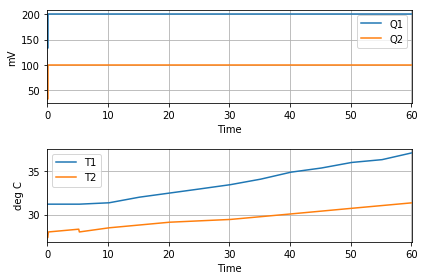

In [8]:
a.plot()

## Realtime Plotting

Real time plotting is available within Jupyter notebooks. The command

    a.initplot(tfinal)
    
initializes plotting with the horizontal axis set from 0 to `tfinal`. Subsequent commands

    a.updateplot()

extend the plots of all four attributes `.T1`, `.T2`, `.Q1` and `.Q2`. This would commonly be include in a `clock(tfinal)` loop to create real-time plots.

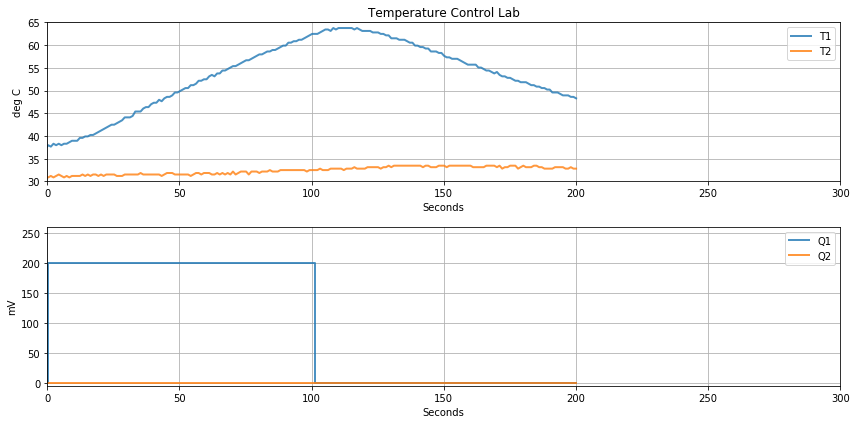

TCLab disconnected successfully.


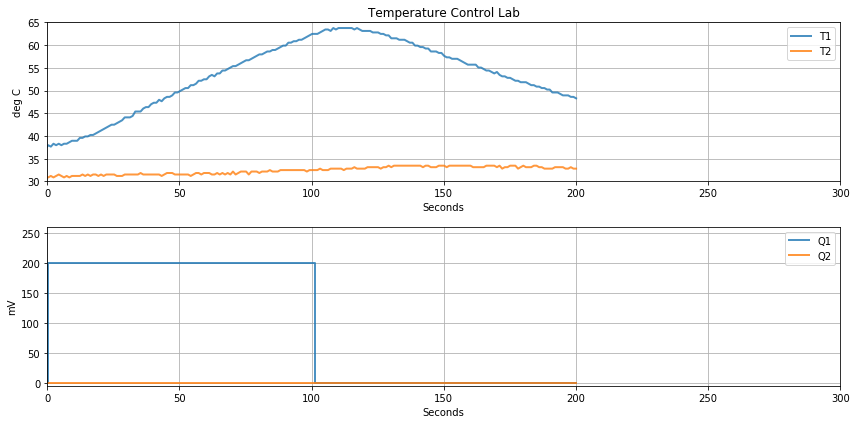

In [9]:
%matplotlib inline 
import sys
sys.path.append('..')
from TCLab import TCLab, clock

tfinal = 200

with TCLab() as a:
    a.initplot(tfinal)
    for t in clock(tfinal):
        a.Q1 = 200 if t < 100 else 0
        a.updateplot()